# Survival Analysis


## 1. Importing necessary libraries


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from lifelines.plotting import add_at_risk_counts

C:\Users\HP\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 2. Loading the Data


In [4]:
telecom = pd.read_csv("data/telco.csv")

telecom.head()

,ID,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,1,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,2,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,3,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,4,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,5,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No


## 3. Data Exploration

In [9]:
#Here, we're getting basic information about the dataset.
print (" Number of Rows:   " , telecom.shape[0])
print (" Number of Columns: " , telecom.shape[1])

#Here, we're checking for missing values in the dataset.
telecom.isnull().sum()

#As we can see, there are no missing values, so that means we can proceed with the data exploration.
#Since, there are many categorical features, and we can't work with those, we need to convert them into appropriate
#format to model the data.




 Number of Rows:    1000
 Number of Columns:  15


ID          0
region      0
tenure      0
age         0
marital     0
address     0
income      0
ed          0
retire      0
gender      0
voice       0
internet    0
forward     0
custcat     0
churn       0
dtype: int64

## 4. Data Preprocessing

In [10]:
#Let's store here the categorical columns.
categorical_cols = ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat', 'churn']

#Now, when we have the categorical columns stored separately, let's get the unique values in each of them.

for col in categorical_cols:
    print(f"{col} unique values: {telecom[col].unique()}")

    
#In this step, we will convert categorical columns with multiple categories into separate numeric columns with values
#0 or 1.

multi_category_cols = ['region', 'marital', 'ed', 'gender', 'custcat']

telecom_encoded = pd.get_dummies(telecom, columns=multi_category_cols, drop_first=True)

#Here, we're converting binary columns into numeric columns with values 0 and 1 too.
binary_cols = ['retire', 'voice', 'internet', 'forward', 'churn']
for col in binary_cols:
    telecom_encoded[col] = telecom_encoded[col].map({'Yes': 1, 'No': 0})
    
    
#Here, we're converting any other True/False columns into columns with values 0 and 1.     
bool_cols = telecom_encoded.select_dtypes(include='bool').columns


telecom_encoded[bool_cols] = telecom_encoded[bool_cols].astype(int)

#I renamed "churn" to "churn_flag" just to be clear.
telecom_encoded.rename(columns={'churn': 'churn_flag'}, inplace=True)



telecom_encoded.head()



region unique values: ['Zone 2' 'Zone 3' 'Zone 1']
marital unique values: ['Married' 'Unmarried']
ed unique values: ['College degree' 'Post-undergraduate degree'
 'Did not complete high school' 'High school degree' 'Some college']
retire unique values: ['No' 'Yes']
gender unique values: ['Male' 'Female']
voice unique values: ['No' 'Yes']
internet unique values: ['No' 'Yes']
forward unique values: ['Yes' 'No']
custcat unique values: ['Basic service' 'Total service' 'Plus service' 'E-service']
churn unique values: ['Yes' 'No']


,ID,tenure,age,address,income,retire,voice,internet,forward,churn_flag,...,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,ed_Post-undergraduate degree,ed_Some college,gender_Male,custcat_E-service,custcat_Plus service,custcat_Total service
0,1,13,44,9,64,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
1,2,11,33,7,136,0,1,0,1,1,...,1,0,0,0,1,0,1,0,0,1
2,3,68,52,24,116,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
3,4,33,33,12,33,0,0,0,0,1,...,0,1,0,1,0,0,0,0,0,0
4,5,23,30,9,30,0,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0


## 5. EDA (to understand what we are dealing with)

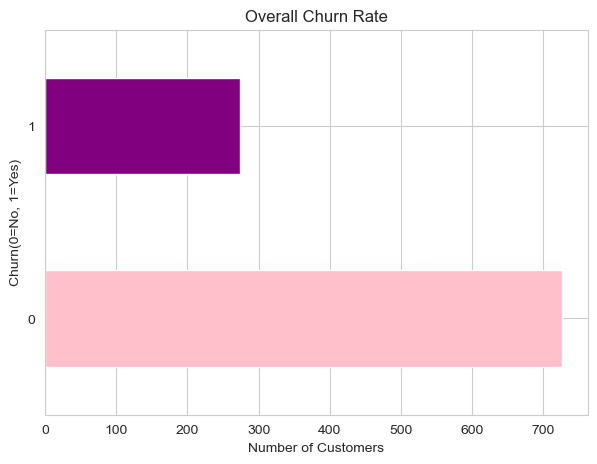

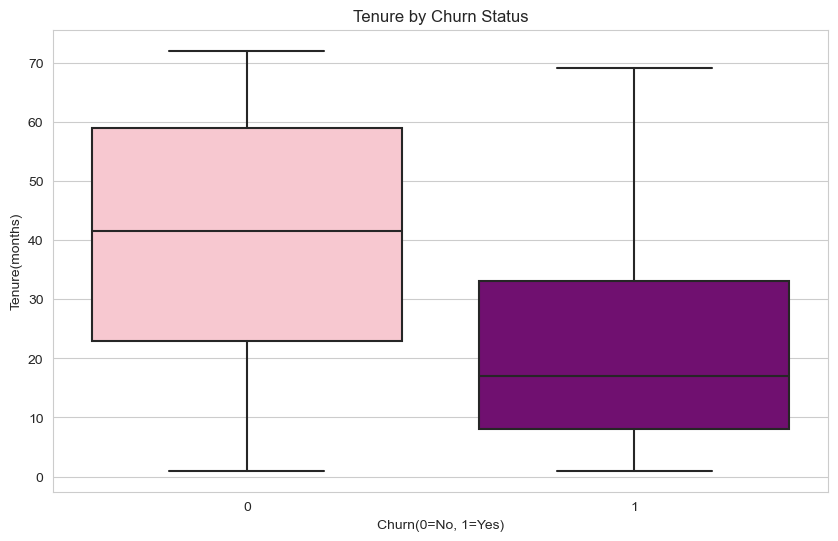

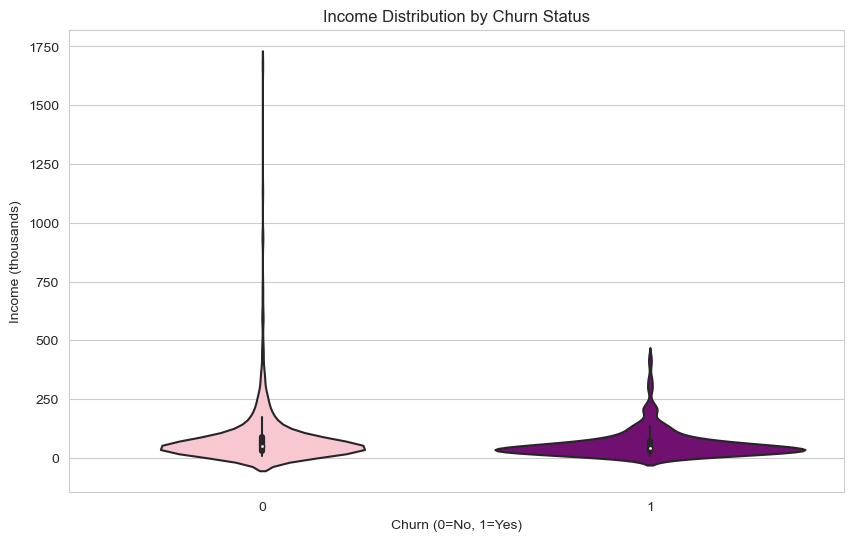

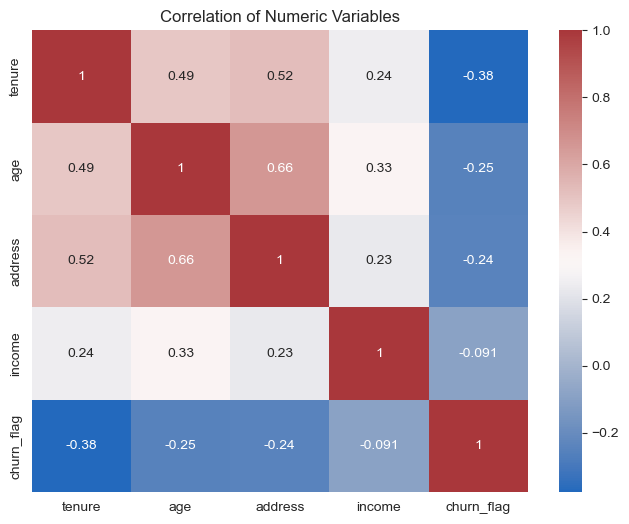

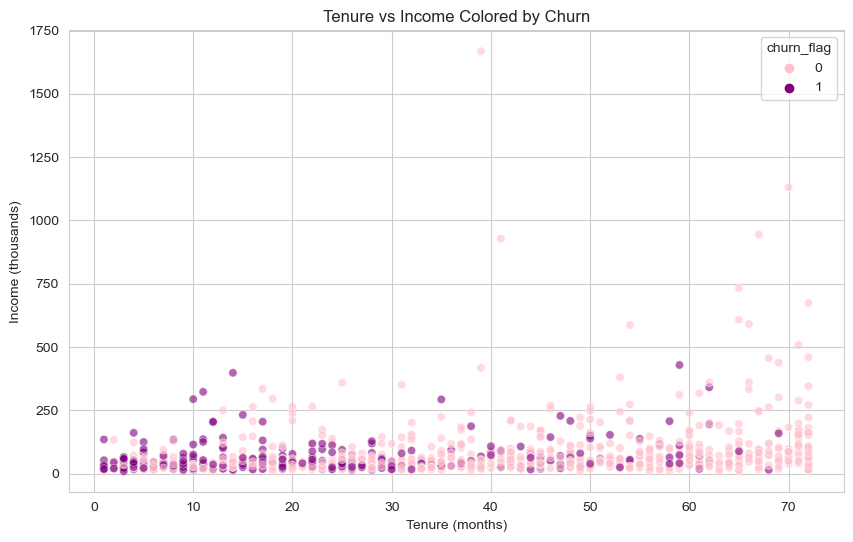

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")  

#For the first plot, we're exploring the overall churn rate to see if the dataset is balanced.
plt.figure(figsize=(7,5))
telecom_encoded['churn_flag'].value_counts().sort_index().plot(kind='barh', color=['pink','purple'])
plt.title('Overall Churn Rate')
plt.xlabel('Number of Customers')
plt.ylabel('Churn(0=No, 1=Yes)')
plt.show()

#This second plot is visualized to see the tenure distribution by churn. This explains how tenure affects churn.
plt.figure(figsize=(10,6))
sns.boxplot(x='churn_flag', y='tenure', data=telecom_encoded, palette=['pink','purple'])
plt.title('Tenure by Churn Status')
plt.xlabel('Churn(0=No, 1=Yes)')
plt.ylabel('Tenure(months)')
plt.show()

#Here, we look at the income differences by churn.
plt.figure(figsize=(10,6))
sns.violinplot(x='churn_flag', y='income', data=telecom_encoded, palette=['pink','purple'])
plt.title('Income Distribution by Churn Status')
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Income (thousands)')
plt.show()

#This is a correlation heatmap for numeric variables, which is for detecting relationships between numeric features.
numerical_cols = ['tenure', 'age', 'address', 'income']
plt.figure(figsize=(8,6))
sns.heatmap(telecom_encoded[numerical_cols + ['churn_flag']].corr(), annot=True, cmap='vlag')
plt.title('Correlation of Numeric Variables')
plt.show()

#Tenure vs Income colored by churn.
plt.figure(figsize=(10,6))
sns.scatterplot(x='tenure', y='income', hue='churn_flag', data=telecom_encoded, palette=['pink','purple'], alpha=0.6)
plt.title('Tenure vs Income Colored by Churn')
plt.xlabel('Tenure (months)')
plt.ylabel('Income (thousands)')
plt.show()


## 6.  Building AFT models.

In [15]:
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter


survival_data = telecom_encoded.copy()

#I decided to build these three AFT models, Fit Weibull AFT model, Fit LogNormal AFT model and 
#Fit LogLogistic AFT model because these are common survival distributions that can handle different patterns of 
#churn over time which we have in our data.



#First, we will build the Fit Weibull AFT model.

weibull_model = WeibullAFTFitter()
weibull_model.fit(
    df = survival_data, 
    duration_col = 'tenure', 
    event_col = 'churn_flag'
)
print("\n Weibull Model Summary")
weibull_model.summary


#Now, here we will build the Fit LogNormal AFT model.

lognormal_model = LogNormalAFTFitter()
lognormal_model.fit(
    df = survival_data, 
    duration_col = 'tenure', 
    event_col = 'churn_flag'
)
print("\n LogNormal Model Summary")
lognormal_model.summary


#Lastly, we will build the Fit LogLogistic AFT model here.

loglogistic_model = LogLogisticAFTFitter()
loglogistic_model.fit(
    df = survival_data, 
    duration_col = 'tenure', 
    event_col = 'churn_flag'
)
print("\n LogLogistic Model Summary")
loglogistic_model.summary



 Weibull Model Summary

 LogNormal Model Summary

 LogLogistic Model Summary


coef  exp(coef)  se(coef)  \
param  covariate                                                        
alpha_ ID                              -0.000466   0.999535  0.000191   
       address                          0.039359   1.040144  0.008782   
       age                              0.032634   1.033172  0.006890   
       custcat_E-service                1.045089   2.843652  0.164304   
       custcat_Plus service             0.873058   2.394220  0.208542   
       custcat_Total service            1.202327   3.327851  0.240200   
       ed_Did not complete high school  0.446926   1.563498  0.198554   
       ed_High school degree            0.318642   1.375259  0.153536   
       ed_Post-undergraduate degree    -0.056649   0.944926  0.213360   
       ed_Some college                  0.251714   1.286229  0.154643   
       forward                         -0.195962   0.822043  0.169892   
       gender_Male                      0.021772   1.022011  0.109517   
       income                           0.001017   1.001017  0.000869   
       internet                        -0.814086   0.443044  0.142372   
       marital_Unmarried               -0.432092   0.649150  0.110315   
       region_Zone 2                   -0.045787   0.955245  0.134235   
       region_Zone 3                    0.127776   1.136298  0.135218   
       retire                           0.062463   1.064455  0.474173   
       voice                           -0.364183   0.694764  0.162250   
       Intercept                        2.550418  12.812454  0.292496   
beta_  Intercept                        0.345780   1.413092  0.051003   

                                        coef lower 95%  coef upper 95%  \
param  covariate                                                         
alpha_ ID                                    -0.000840       -0.000091   
       address                                0.022147        0.056572   
       age                                    0.019129        0.046138   
       custcat_E-service                      0.723059        1.367119   
       custcat_Plus service                   0.464324        1.281792   
       custcat_Total service                  0.731544        1.673110   
       ed_Did not complete high school        0.057768        0.836084   
       ed_High school degree                  0.017717        0.619567   
       ed_Post-undergraduate degree          -0.474827        0.361529   
       ed_Some college                       -0.051381        0.554810   
       forward                               -0.528945        0.137021   
       gender_Male                           -0.192878        0.236422   
       income                                -0.000686        0.002719   
       internet                              -1.093129       -0.535043   
       marital_Unmarried                     -0.648306       -0.215878   
       region_Zone 2                         -0.308883        0.217308   
       region_Zone 3                         -0.137246        0.392797   
       retire                                -0.866899        0.991825   
       voice                                 -0.682188       -0.046178   
       Intercept                              1.977136        3.123699   
beta_  Intercept                              0.245816        0.445744   

                                        exp(coef) lower 95%  \
param  covariate                                              
alpha_ ID                                          0.999160   
       address                                     1.022394   
       age                                         1.019313   
       custcat_E-service                           2.060728   
       custcat_Plus service                        1.590938   
       custcat_Total service                       2.078286   
       ed_Did not complete high school             1.059469   
       ed_High school degree                       1.017875   
       ed_Post-undergraduate de

## 7. Comparing the models.

In [19]:
#Now when we have the models, we need to compare them.
#For the comparison we will use the AIC(Akaike Information Criterion), which is an estimator of prediction error and
#in this case it will tell us which model fits the data best.
#We will identify this by looking at how low the AIC is. A lower AIC means a model explains the churn data well 
#without being too complex.


from lifelines.utils import concordance_index


weibull_aic_val      = weibull_model.AIC_

lognormal_aic_val    = lognormal_model.AIC_

loglogistic_aic_val  = loglogistic_model.AIC_


weibull_c_index      = concordance_index(
    survival_data['tenure'],
    -weibull_model.predict_median(survival_data),
    survival_data['churn_flag']
)

lognormal_c_index    = concordance_index(
    survival_data['tenure'],
    -lognormal_model.predict_median(survival_data),
    survival_data['churn_flag']
)

loglogistic_c_index  = concordance_index(
    survival_data['tenure'],
    -loglogistic_model.predict_median(survival_data),
    survival_data['churn_flag']
)


model_comparison_df = pd.DataFrame({
    'Model': ['Weibull AFT', 'LogNormal AFT', 'LogLogistic AFT'],
    'AIC': [weibull_aic_val, lognormal_aic_val, loglogistic_aic_val],
    'Concordance Index': [weibull_c_index, lognormal_c_index, loglogistic_c_index]
})


model_comparison_df.sort_values(by='AIC')

#As we can see from the results below, LogNormal AFT had the lowest score, where AIC=2950.300213.


,Model,AIC,Concordance Index
1,LogNormal AFT,2950.300213,0.210604
2,LogLogistic AFT,2952.258260,0.210212
0,Weibull AFT,2958.357127,0.215151


## 8. Visualizing all the curves.

To make the comparison more complete and extensive, I decided to visualize the survival curves in two ways.

First, I decided to plot the average survival curve across the whole dataset, which helps compare the general shape and behavior of each AFT model.

After this, I also decided to plot the survival curves for a one single customer, because the mean survival curve shows the overall trend for all customers, but survival analysis is also used to make predictions for individual people. That’s why I wanted to look at one customer’s survival curve as well. It helps us see how stable and clear each model’s prediction is, and how differently each model handles time-to-churn for one single person.


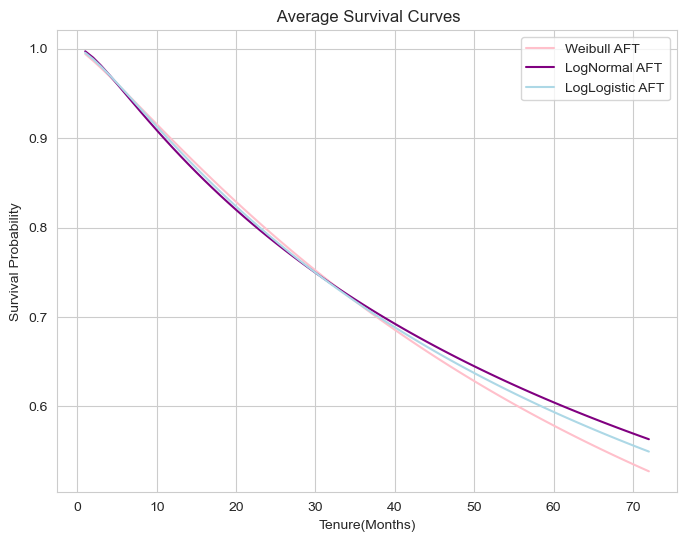

In [26]:
#Average Survival Curve.

plt.figure(figsize=(8, 6))


weibull_curve = weibull_model.predict_survival_function(survival_data).mean(axis=1)
plt.plot(weibull_curve.index,
         weibull_curve.values,
         label="Weibull AFT", 
         color="pink")


lognormal_curve = lognormal_model.predict_survival_function(survival_data).mean(axis=1)
plt.plot(lognormal_curve.index, 
         lognormal_curve.values, 
         label="LogNormal AFT", 
         color="purple")


loglogistic_curve = loglogistic_model.predict_survival_function(survival_data).mean(axis=1)
plt.plot(loglogistic_curve.index,
         loglogistic_curve.values,
         label="LogLogistic AFT", 
         color="lightblue")


plt.title(" Average Survival Curves")
plt.xlabel("Tenure(Months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()


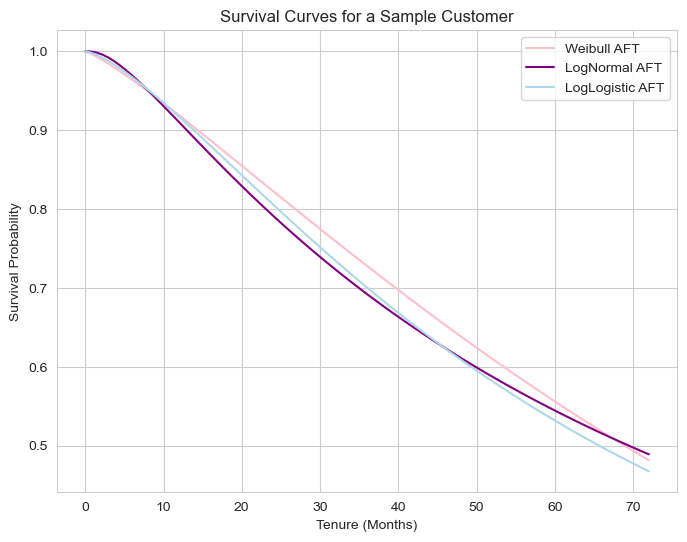

In [27]:
#Survival curves for one single sample.
timeline = np.linspace(0, survival_data['tenure'].max(), 100)


example = survival_data.iloc[[0]]

plt.figure(figsize=(8, 6))


w_curve = weibull_model.predict_survival_function(example, times=timeline)
plt.plot(timeline,
         w_curve.values.flatten(), 
         label="Weibull AFT", 
         color="pink")


ln_curve = lognormal_model.predict_survival_function(example, times=timeline)
plt.plot(timeline,
         ln_curve.values.flatten(), 
         label="LogNormal AFT", 
         color="purple")


ll_curve = loglogistic_model.predict_survival_function(example, times=timeline)
plt.plot(timeline, 
         ll_curve.values.flatten(), 
         label="LogLogistic AFT", 
         color="lightblue")

plt.title("Survival Curves for a Sample Customer")
plt.xlabel("Tenure (Months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()


## 9. Selecting the model

I decided to select the LogNormal AFT model as the main survival model because it gave us the best overall fit for predicting customer churn based on AIC score and the plots visualized above. Among the three parametric AFT models, LogNormal achieves the lowest AIC, which just means that it models the distribution of customer tenure more accurately than Weibull model or LogLogistic model. Its survival curve is smooth and easy to interpret because it gave predictions that match the overall pattern of churn in the dataset. Although the Weibull model had a slightly higher concordance index, that difference was very small and not significant. To my way of thinking, the AIC is the more reliable criterion here, so according to this logic the LogNormal AFT model looks like the most appropriate choice for our analysis.

## 10.  Keeping the significant features.

In [34]:
lognormal_summary = lognormal_model.summary

#Here, we do this to see which of the features are significant and which aren't.

significant_features = lognormal_model.summary[lognormal_model.summary['p'] < 0.05]

#As we can see, the significant features are ID, address, age, custcat_E-service, custcat_Plus service,
#custcat_Total service, internet, marital_Unmarried, voice and Intercept.

sig_feature_list = [cov for param, cov in significant_features.index if cov != 'Intercept']


sig_feature_list.append('Intercept')


print("Significant features:", sig_feature_list)


# So, here we will keep all the significant features we found above and the tenure and churn columns.
final_features = ['tenure', 'churn_flag'] + sig_feature_list


final_features = [col for col in final_features if col in telecom_encoded.columns]


final_data = telecom_encoded[final_features]


#Finally, we refit the chosen model with only the significant features kept.
final_model = LogNormalAFTFitter()
final_model.fit(final_data, duration_col='tenure', event_col='churn_flag')


final_model.summary




Significant features: ['ID', 'address', 'age', 'custcat_E-service', 'custcat_Plus service', 'custcat_Total service', 'internet', 'marital_Unmarried', 'voice', 'Intercept']


coef  exp(coef)  se(coef)  coef lower 95%  \
param  covariate                                                              
mu_    ID                    -0.000457   0.999543  0.000198       -0.000845   
       address                0.042883   1.043816  0.008823        0.025589   
       age                    0.037307   1.038011  0.006388        0.024786   
       custcat_E-service      1.024231   2.784954  0.168257        0.694453   
       custcat_Plus service   0.831780   2.297404  0.168815        0.500909   
       custcat_Total service  1.018092   2.767909  0.208828        0.608797   
       internet              -0.857279   0.424315  0.137969       -1.127692   
       marital_Unmarried     -0.436341   0.646397  0.114000       -0.659777   
       voice                 -0.441509   0.643065  0.166298       -0.767447   
       Intercept              2.733675  15.389337  0.257150        2.229671   
sigma_ Intercept              0.277377   1.319663  0.046000        0.187217   

                              coef upper 95%  exp(coef) lower 95%  \
param  covariate                                                    
mu_    ID                          -0.000069             0.999155   
       address                      0.060176             1.025920   
       age                          0.049827             1.025096   
       custcat_E-service            1.354010             2.002613   
       custcat_Plus service         1.162650             1.650221   
       custcat_Total service        1.427387             1.838219   
       internet                    -0.586865             0.323780   
       marital_Unmarried           -0.212906             0.516967   
       voice                       -0.115572             0.464197   
       Intercept                    3.237679             9.296803   
sigma_ Intercept                    0.367536             1.205889   

                              exp(coef) upper 95%  cmp to          z  \
param  covariate                                                       
mu_    ID                                0.999931     0.0  -2.308290   
       address                           1.062024     0.0   4.860190   
       age                               1.051089     0.0   5.840049   
       custcat_E-service                 3.872923     0.0   6.087290   
       custcat_Plus service              3.198399     0.0   4.927179   
       custcat_Total service             4.167795     0.0   4.875271   
       internet                          0.556068     0.0  -6.213581   
       marital_Unmarried                 0.808232     0.0  -3.827562   
       voice                             0.890857     0.0  -2.654933   
       Intercept                        25.474532     0.0  10.630671   
sigma_ Intercept                         1.444171     0.0   6.029877   

                                         p   -log2(p)  
param  covariate                                       
mu_    ID                     2.098301e-02   5.574635  
       address                1.172729e-06  19.701698  
       age                    5.218542e-09  27.513706  
       custcat_E-service      1.148378e-09  29.697755  
       custcat_Plus service   8.342545e-07  20.193009  
       custcat_Total service  1.086593e-06  19.811757  
       internet               5.179051e-10  30.846593  
       marital_Unmarried      1.294190e-04  12.915663  
       voice                  7.932422e-03   6.978023  
       Intercept              2.145631e-26  85.268729  
sigma_ Intercept              1.640842e-09  29.182916

##  11. CLV Analysis.

In [38]:
import numpy as np
import matplotlib.pyplot as plt



clv_data = survival_data.copy()

#Here, I'm assuming an example that the average monthly revenue per customer is equal to 60.
avg_monthly_revenue = 60

#Here, I decided to use 48 months as the prediction horizon for CLV. This means we are estimating each customer's
#potential revenue over the next 4 years. So, the survival probabilities are calculated month by month up to month 48.

timeline = np.linspace(0, 48, 49)


clv_list = []


for index, row in clv_data.iterrows():
    customer_df = pd.DataFrame([row])
    survival_prob = final_model.predict_survival_function(customer_df, times=timeline).values.flatten()
    discount_factors = np.array([(1 / (1 + 0.01)) ** t for t in range(len(timeline))])
    clv = avg_monthly_revenue * np.sum(survival_prob * discount_factors)
    clv_list.append(clv)


clv_data['CLV'] = clv_list


print("CLV Summary Statistics:")
print(clv_data['CLV'].describe())





CLV Summary Statistics:
count    1000.000000
mean     1918.277117
std       357.358686
min       459.663516
25%      1673.102741
50%      2006.568006
75%      2221.184681
max      2338.114693
Name: CLV, dtype: float64


## 12. Visualizing CLV.

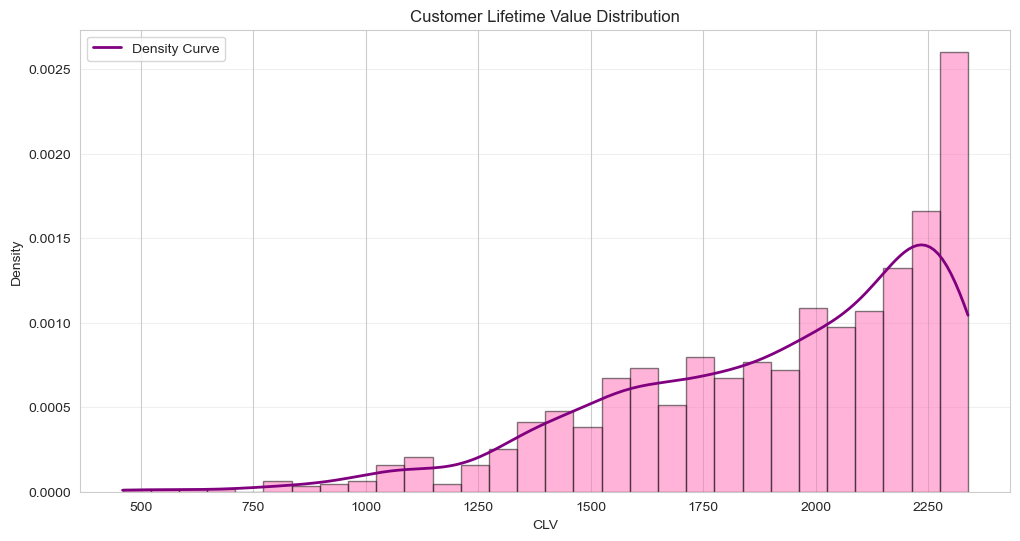

In [44]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np


clv_values = clv_data['CLV'].values


plt.figure(figsize=(12, 6))
plt.hist(clv_values, 
         bins=30, 
         density=True,
         color='hotpink',
         edgecolor='black',
         alpha=0.5)


kde = gaussian_kde(clv_values)
x_vals = np.linspace(min(clv_values), max(clv_values), 200)
plt.plot(x_vals,
         kde(x_vals), 
         color='purple',
         lw=2, 
         label='Density Curve')

plt.title('Customer Lifetime Value Distribution')
plt.xlabel('CLV')
plt.ylabel('Density')

plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.show()


## 13. CLV exploration within segments.

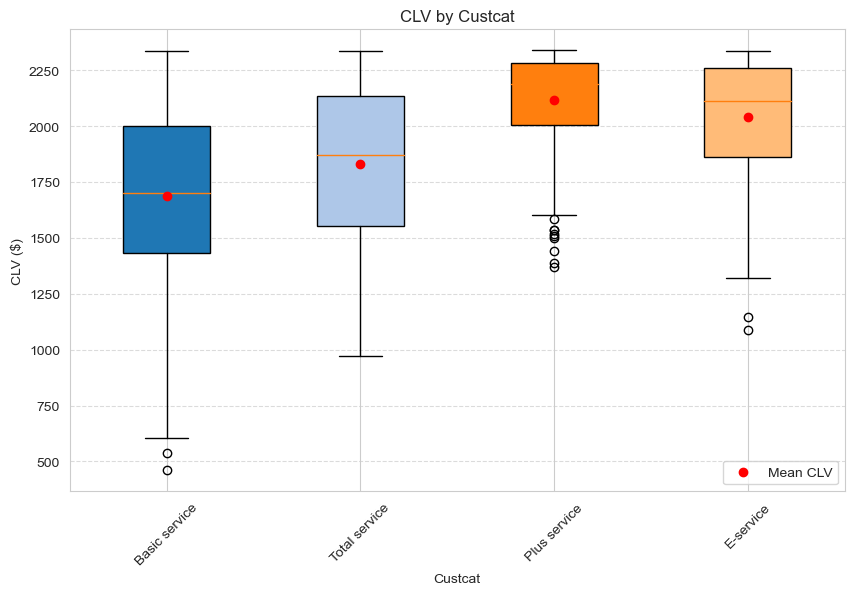

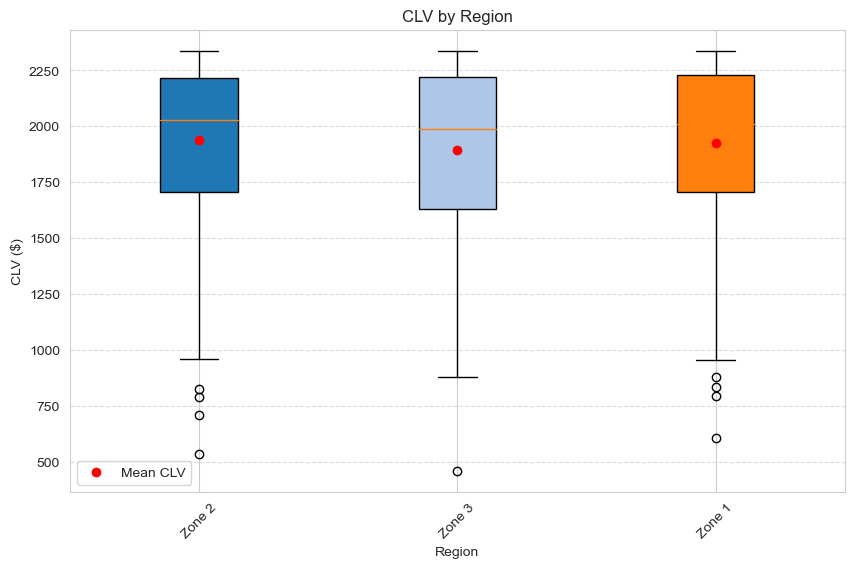

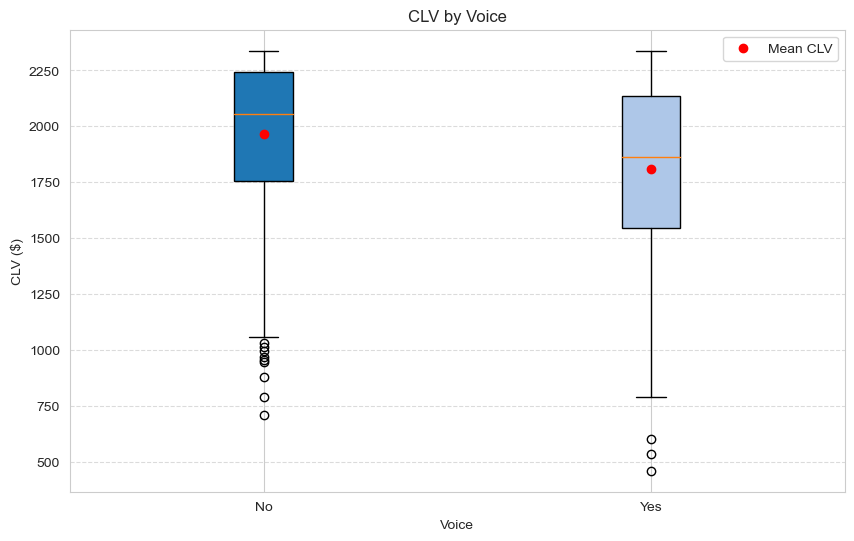

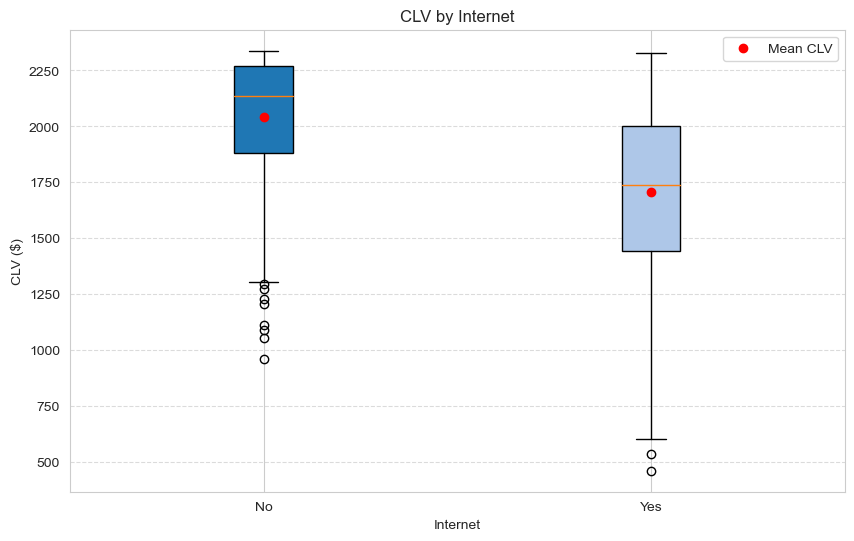

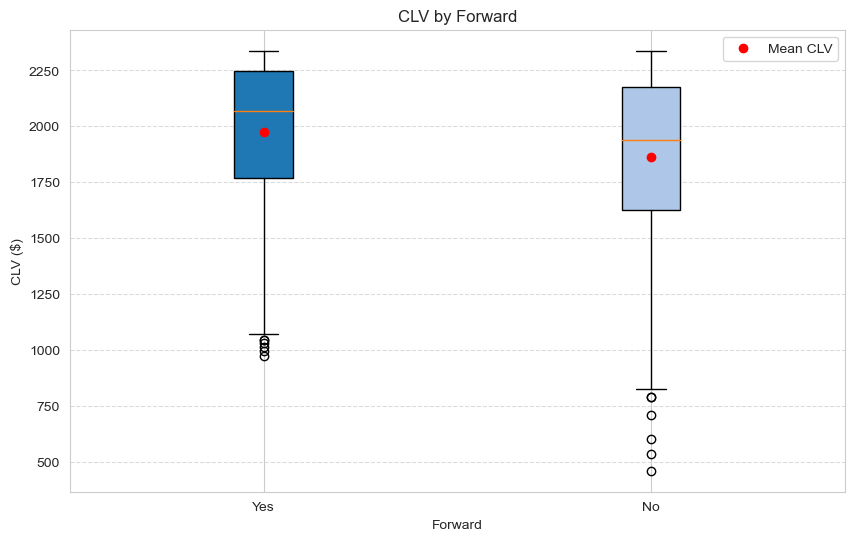

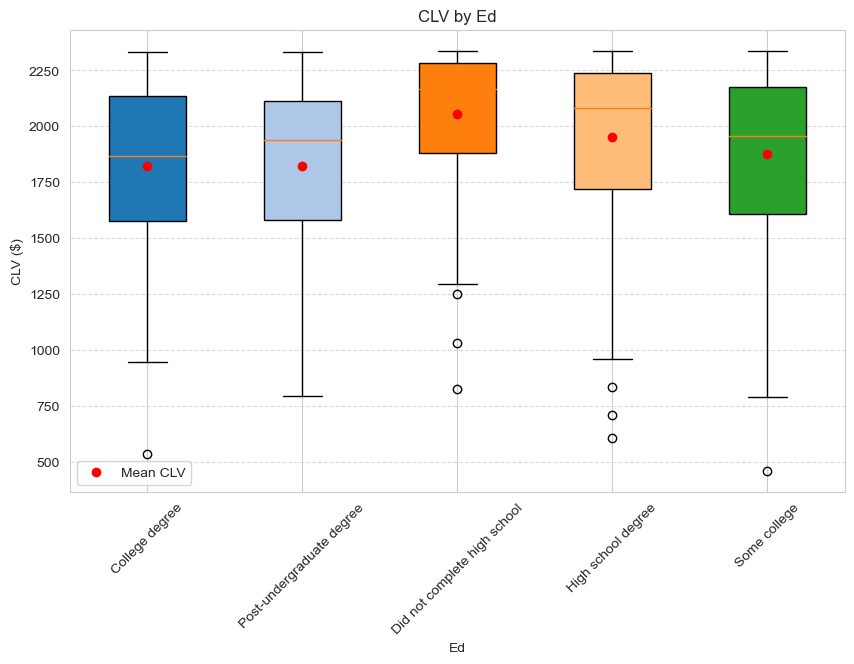

In [49]:
telecom_clv = telecom.copy()
telecom_clv['CLV'] = clv_data['CLV']  

# We will be exploring the CLV within the following segments:
segments = ['custcat', 'region', 'voice', 'internet', 'forward', 'ed']


for seg in segments:
    plt.figure(figsize=(10, 6))
    unique_values = telecom_clv[seg].unique()
    data_to_plot = [telecom_clv[telecom_clv[seg] == val]['CLV'] for val in unique_values]
    
    box = plt.boxplot(data_to_plot, patch_artist=True, labels=unique_values)
    
    
    colors = plt.cm.tab20.colors
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    
    means = [np.mean(group) for group in data_to_plot]
    plt.scatter(range(1, len(means)+1), means, color='red', zorder=5, label='Mean CLV')
    
    
    plt.title(f'CLV by {seg.capitalize()}')
    plt.xlabel(seg.capitalize())
    plt.ylabel('CLV ($)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    
    if seg in ['ed', 'region', 'custcat']:
        plt.xticks(rotation=45)
    
    plt.show()



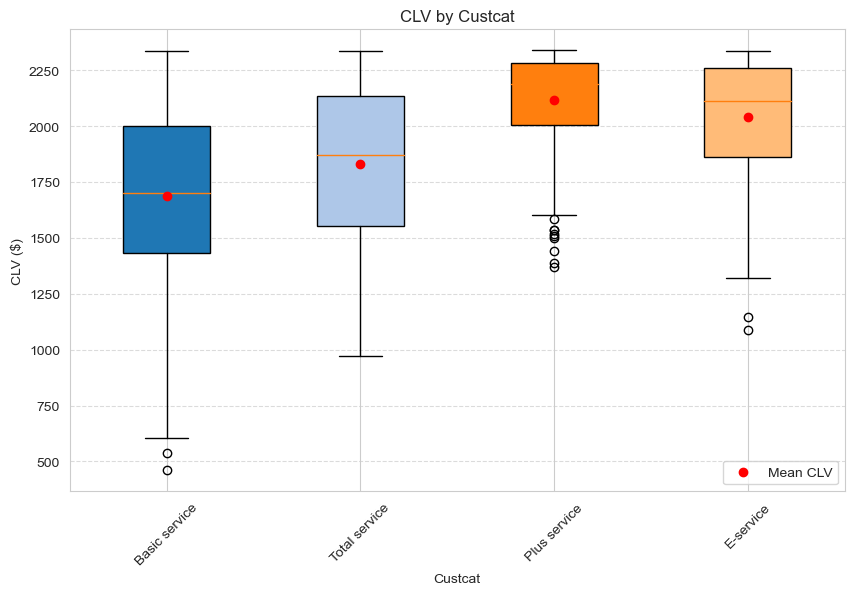

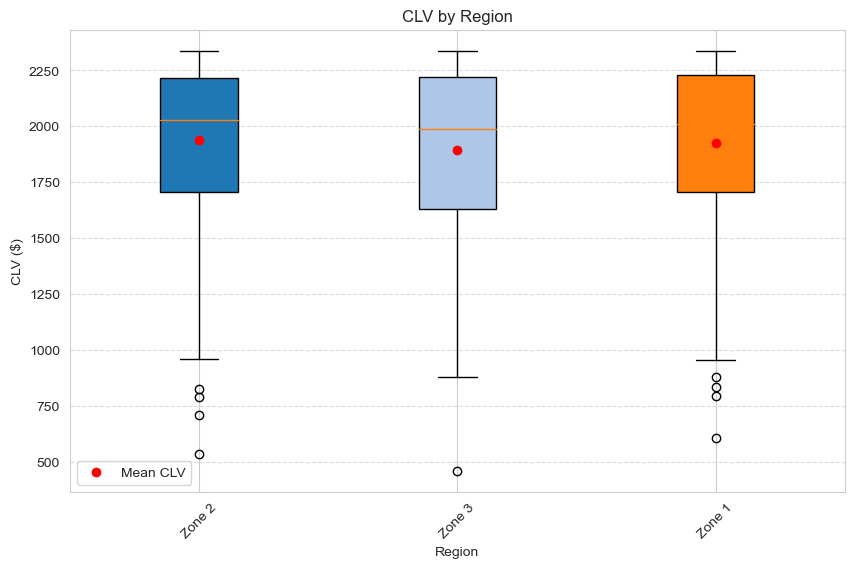

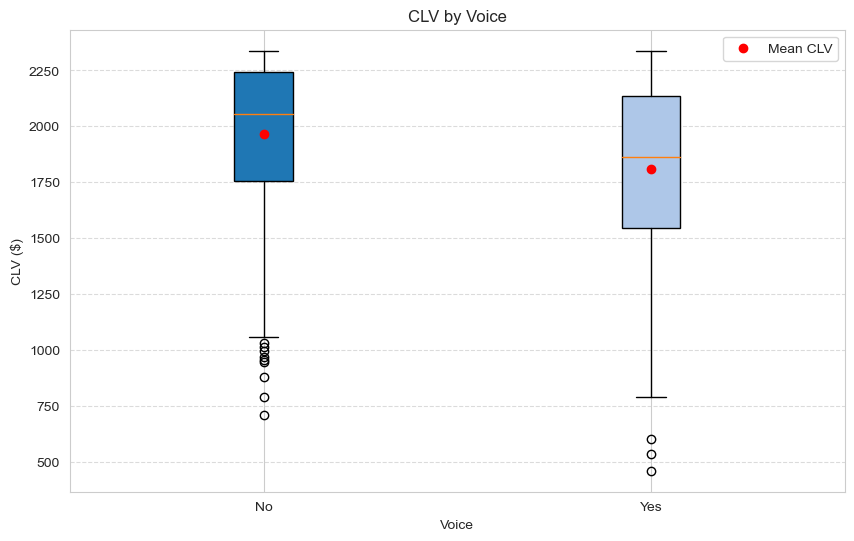

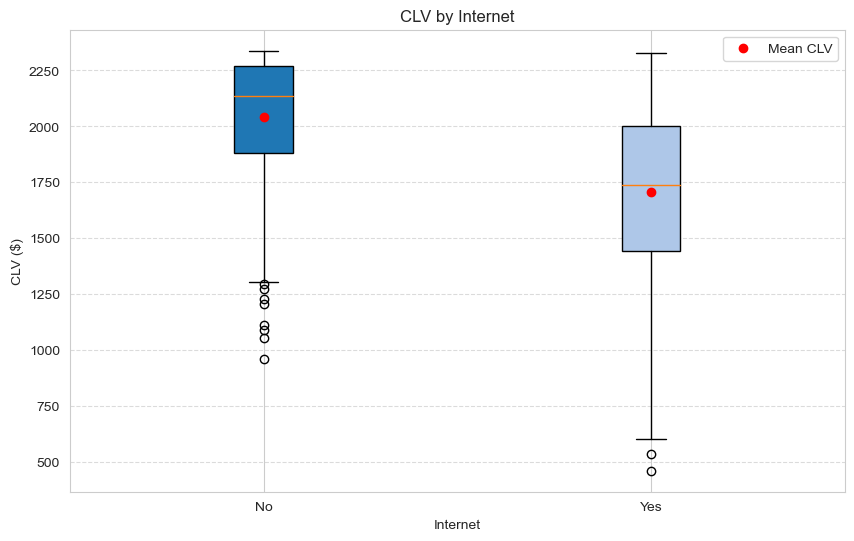

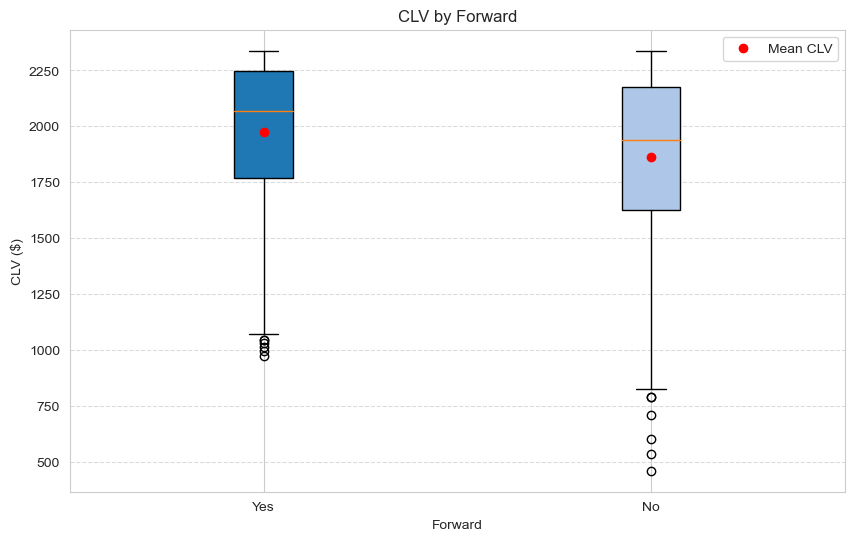

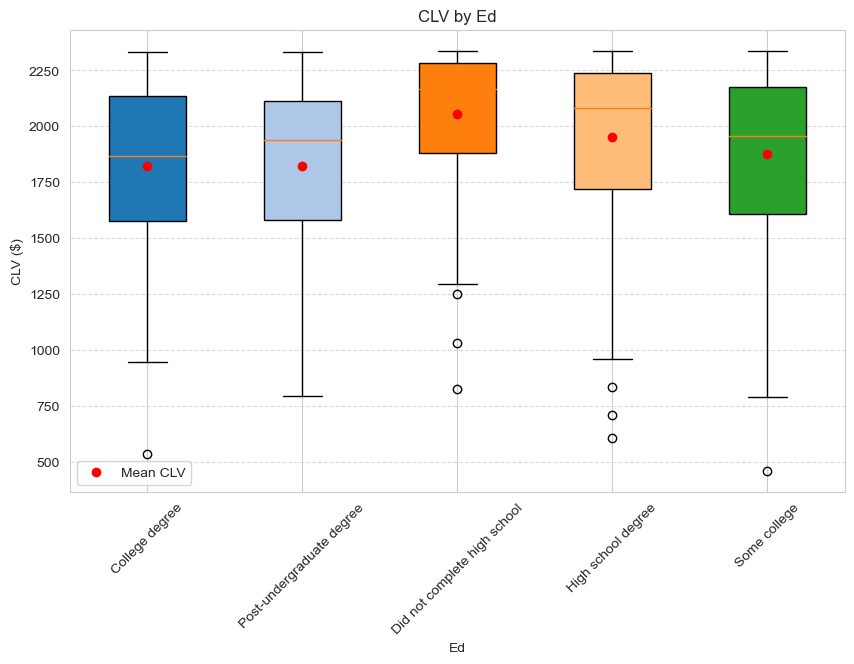

In [55]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np



# CLV by segments
telecom_clv = telecom.copy()
telecom_clv['CLV'] = clv_data['CLV']  

segments = ['custcat', 'region', 'voice', 'internet', 'forward', 'ed']

for seg in segments:
    plt.figure(figsize=(10, 6))
    unique_values = telecom_clv[seg].unique()
    data_to_plot = [telecom_clv[telecom_clv[seg] == val]['CLV'] for val in unique_values]
    
    box = plt.boxplot(data_to_plot, patch_artist=True, labels=unique_values)
    
    # Use colors cyclically if more groups than colors
    colors = plt.cm.tab20.colors
    for i, patch in enumerate(box['boxes']):
        patch.set_facecolor(colors[i % len(colors)])
    
    means = [np.mean(group) for group in data_to_plot]
    plt.scatter(range(1, len(means)+1), means, color='red', zorder=5, label='Mean CLV')
    
    plt.title(f'CLV by {seg.capitalize()}')
    plt.xlabel(seg.capitalize())
    plt.ylabel('CLV ($)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    if seg in ['ed', 'region', 'custcat']:
        plt.xticks(rotation=45)



In [59]:
import pandas as pd
import numpy as np

telecom_clv = telecom.copy()


telecom_clv['CLV'] = clv_data['CLV']


timeline_12m = np.array([12])
churn_probs_12m = []

for _, customer in telecom_encoded.iterrows():
    customer_df = pd.DataFrame([customer])
    survival_12m = final_model.predict_survival_function(customer_df, times=timeline_12m).values.flatten()[0]
    churn_probs_12m.append(1 - survival_12m)

telecom_clv['churn_12m'] = churn_probs_12m


top_25pct_clv = telecom_clv['CLV'].quantile(0.75)
top_25pct_churn = telecom_clv['churn_12m'].quantile(0.75)

telecom_clv['high_value'] = telecom_clv['CLV'] >= top_25pct_clv
telecom_clv['high_risk'] = telecom_clv['churn_12m'] >= top_25pct_churn
telecom_clv['high_value_at_risk'] = telecom_clv['high_value'] & telecom_clv['high_risk']

print("High-value customers:", telecom_clv['high_value'].sum())
print("High-risk customers:", telecom_clv['high_risk'].sum())
print("High-value at-risk customers:", telecom_clv['high_value_at_risk'].sum())


if telecom_clv['high_value_at_risk'].sum() > 0:
    annual_revenue_loss = (
        telecom_clv.loc[telecom_clv['high_value_at_risk'], 'CLV'].sum() *
        telecom_clv.loc[telecom_clv['high_value_at_risk'], 'churn_12m'].mean()
    )
else:
   
    alt_value_threshold = telecom_clv['CLV'].quantile(0.90)
    alt_risk_threshold = telecom_clv['churn_12m'].mean()
    telecom_clv['alternative_segment'] = (
        (telecom_clv['CLV'] >= alt_value_threshold) & 
        (telecom_clv['churn_12m'] >= alt_risk_threshold)
    )
    if telecom_clv['alternative_segment'].sum() > 0:
        annual_revenue_loss = (
            telecom_clv.loc[telecom_clv['alternative_segment'], 'CLV'].sum() *
            telecom_clv.loc[telecom_clv['alternative_segment'], 'churn_12m'].mean()
        )
        print(f"Using alternative segment: {telecom_clv['alternative_segment'].sum()} customers")
    else:
        annual_revenue_loss = (
            telecom_clv.loc[telecom_clv['high_value'], 'CLV'].sum() *
            telecom_clv['churn_12m'].mean()
        )
        print("Using all high-value customers for revenue loss calculation")

print(f"Estimated potential annual revenue loss: ${annual_revenue_loss:.2f}")


retention_budget = annual_revenue_loss * 0.20  
print(f"Suggested retention budget: ${retention_budget:.2f}")


segment_summary = telecom_clv.groupby('custcat').agg({
    'CLV': 'mean',
    'churn_12m': 'mean',
    'ID': 'count'
}).rename(columns={'ID': 'count'}).reset_index()

print("\nSegment-level CLV & Churn Analysis:")
print(segment_summary)


multi_segment_summary = telecom_clv.groupby(['custcat', 'voice', 'internet']).agg({
    'CLV': 'mean',
    'ID': 'count'
}).rename(columns={'ID': 'count'}).reset_index().sort_values('CLV', ascending=False)

print("\nTop 10 segment combinations by average CLV:")
print(multi_segment_summary.head(10))


High-value customers: 250
High-risk customers: 250
High-value at-risk customers: 0
Using all high-value customers for revenue loss calculation
Estimated potential annual revenue loss: $63120.24
Suggested retention budget: $12624.05

Segment-level CLV & Churn Analysis:
         custcat          CLV  churn_12m  count
0  Basic service  1688.235986   0.189695    266
1      E-service  2039.315629   0.068367    217
2   Plus service  2115.478326   0.046237    281
3  Total service  1831.463741   0.135940    236

Top 10 segment combinations by average CLV:
          custcat voice internet          CLV  count
4       E-service    No       No  2201.186056    100
8    Plus service    No       No  2159.576180    212
12  Total service    No       No  2159.317980      8
14  Total service   Yes       No  2125.913127     55
10   Plus service   Yes       No  2022.901542     47
6       E-service   Yes       No  2004.230187      7
9    Plus service    No      Yes  1950.558277     16
5       E-service    N